# ANALYSIS ON THE VEHICLE 14710_129450

In [1]:
vehicle_code = "14710_129450"
stop = "5"

### IMPORT LIBRARIES

In [2]:
# psycopg2 is a library to execute sql queries in python
import psycopg2
# folium allows to visualize geolocalized data with the jupyter notebook
import folium
from folium.plugins import MarkerCluster
# sys is required to use the open function to write on file
import sys
# pandas is needed to read the csv file and to perform some basic operations on dataframes
import pandas as pd
# matplotlib is used to draw graphs
import matplotlib.pyplot as plt
# numpy is for scinetific computations
import numpy as np
# ST_AsGeoJSON returns a json object, so we can use json.load to parse it
import json
# scatter plot with color density
from scipy.stats import gaussian_kde

**WARNING! RUN ONLY ONCE TO SAVE THE CSV FILES!**

**YOU DON'T NEED TO CONNECT TO THE SERVER ONCE YOU ALREADY HAVE THE FILES**

### CONNECT TO THE DATASET

In [3]:
conn = psycopg2.connect("dbname=irpet", host="146.48.83.137", user="sbolgi", password="sbolgi2019", port="5435")

# the cursor allows Python code to execute PostgreSQL command in a database session.
cur = conn.cursor()

In [4]:
# First query: select all trajectories of vehicle 14710_129450
query1 = "SELECT * FROM tak.vodafone_zel1_traj_"+stop+"min WHERE vehicle = '"+ vehicle_code+"'"

# Store result in csv file to perform then other experiments
outputquery = "COPY ({0}) TO STDOUT WITH CSV HEADER".format(query1)

with open('../../../datasets/in/Traj'+stop+'min/vehicle_'+vehicle_code+'.csv', 'w', encoding='utf-8') as f:
    cur.copy_expert(outputquery, f)

In [5]:
# Store result in csv file but this time geometry is converted to coordinates

# First query: select all trajectories of vehicle 14710_129450
query1 = """
    SELECT vehicle, tid, ST_AsGeoJSON(traj) as trajcoord, company, vehicletype, length, duration, start_time, end_time
    FROM tak.vodafone_zel1_traj_"""+stop+"min WHERE vehicle = '"+ vehicle_code+"'"

# Store result in csv file to perform then other experiments
outputquery = "COPY ({0}) TO STDOUT WITH CSV HEADER".format(query1)

with open('../../../datasets/out/Traj'+stop+'min/vehicle_'+vehicle_code+'_coord.csv', 'w', encoding='utf-8') as f:
    cur.copy_expert(outputquery, f)

In [6]:
conn.close()

###### Open csv just created and execute usual statistics

In [7]:
df = pd.read_csv('../../../datasets/in/Traj'+stop+'min/vehicle_'+vehicle_code+'.csv') 

In [8]:
print("The dataset has", df.shape[0], "rows and", df.shape[1], "columns.")

The dataset has 5235 rows and 9 columns.


In [9]:
df.head(5)

,vehicle,tid,traj,company,vehicletype,length,duration,start_time,end_time
0,14710_129450,149,01020000A0E610000002000000C5707500C48D3340DD23...,44130,Van,0.020721,72.0,2017-07-05 14:31:24,2017-07-05 14:32:36
1,14710_129450,169,01020000A0E610000002000000CD9541B5C18D3340E7E4...,44130,Van,0.017873,252.0,2017-07-06 06:30:21,2017-07-06 06:34:33
2,14710_129450,2131,01020000A0E6100000020000007BD7A02FBD8D3340331A...,44130,Van,0.028630,85.0,2017-09-04 05:04:21,2017-09-04 05:05:46
3,14710_129450,2681,01020000A0E610000002000000F645425BCE8D334038D7...,44130,Van,0.018654,288.0,2017-09-17 23:55:23,2017-09-18 00:00:11
4,14710_129450,2683,01020000A0E610000002000000FD4D2844C08D3340D579...,44130,Van,0.014561,98.0,2017-09-18 01:38:03,2017-09-18 01:39:41


In [10]:
print("the vehicle is characterized by 8 fields")
print("tid: has ", len(df["tid"].unique()), "unique values")
print("company: has ", len(df["company"].unique()), "unique values: ", df["company"].unique())
print("vehicletype: has ", len(df["vehicletype"].unique()), "unique values")

the vehicle is characterized by 8 fields
tid: has  5235 unique values
company: has  2 unique values:  ['44130' '\ufeff44130']
vehicletype: has  1 unique values


In [11]:
df[["length", "duration"]].describe()

,length,duration
count,5235.000000,5235.000000
mean,7.023662,760.288157
std,17.662910,1314.405852
min,0.000000,0.050000
25%,0.022311,85.000000
50%,0.114541,240.000000
75%,2.572916,723.500000
max,161.834899,12822.000000


the 90% of the total is  4711.5
the length of the 90% is  23.175888258975714
the duration of the 90% is  2239.0


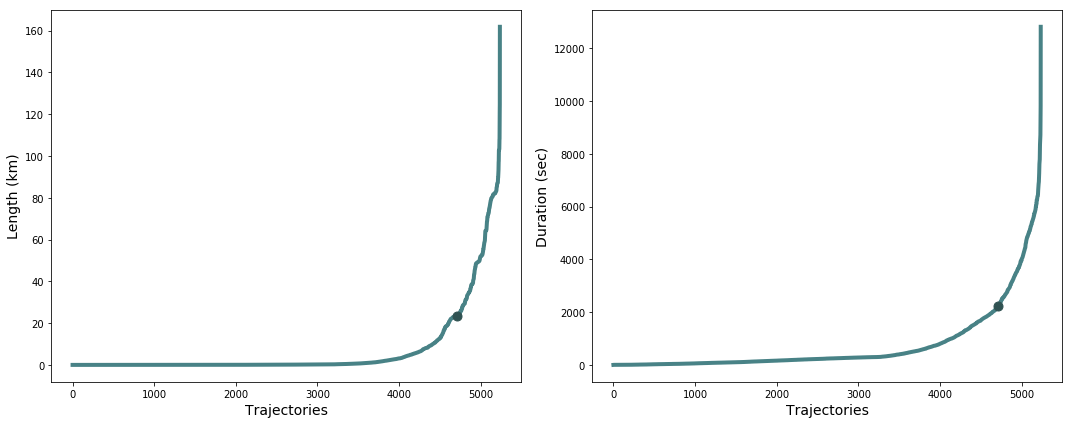

In [12]:
perc90 = (df.shape[0] * 90)/100
print("the 90% of the total is ", perc90)

perc90_i = int(perc90)

print("the length of the 90% is ", sorted(df["length"])[perc90_i])
print("the duration of the 90% is ", sorted(df["duration"])[perc90_i])

fig = plt.figure(figsize=(15, 6)) 
fig_dims = (1, 2)

ax = plt.subplot2grid(fig_dims, (0, 0))
ax.plot(range(0,df.shape[0]), sorted(df["length"]), color='#488286', linewidth=4)
plt.plot(perc90_i, sorted(df["length"])[perc90_i], 'o', color='#305252', markersize=9)
plt.xlabel("Trajectories", fontsize=14)
plt.ylabel("Length (km)", fontsize=14)

ax = plt.subplot2grid(fig_dims, (0, 1))
ax.plot(range(0,df.shape[0]), sorted(df["duration"]), color='#488286', linewidth=4)
plt.plot(perc90_i, sorted(df["duration"])[perc90_i], 'o', color='#305252', markersize=9)
plt.xlabel("Trajectories", fontsize=14)
plt.ylabel("Duration (sec)", fontsize=14)

plt.tight_layout()

plt.savefig('../../../thesis/images/Traj'+stop+'_'+vehicle_code+'_distr.png', format='png', bbox_inches='tight')

### let's zoom on the values "in the area", hence for less than 0.2 km

In [13]:
df_mini = df[df["length"] < 0.2]

The number of trajectories that lasted for less than 200 meters is 3079


C:\Users\Francesca\Anaconda3\lib\site-packages\pandas\core\series.py:942: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


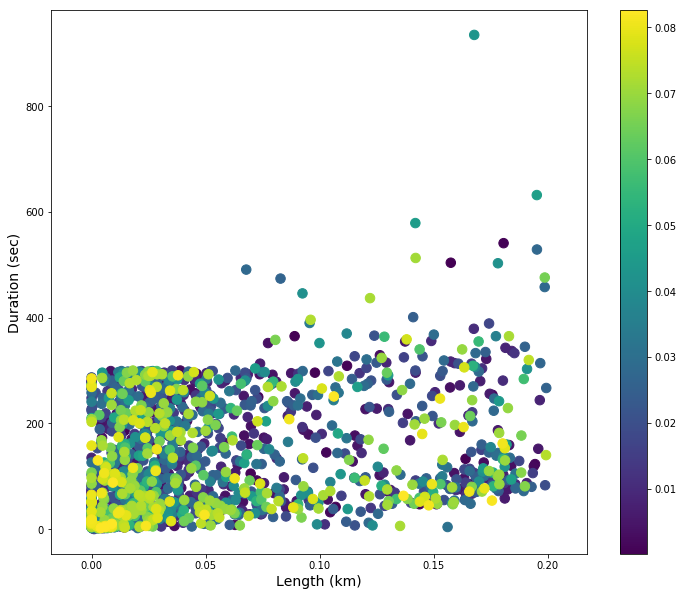

In [14]:
print("The number of trajectories that lasted for less than 200 meters is", df_mini.shape[0])

fig = plt.figure(figsize=(12, 10)) 
fig_dims = (1, 1)

x = df_mini["length"]
y = df_mini["duration"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

ax = plt.subplot2grid(fig_dims, (0, 0))
density = ax.scatter(x, y, c=z, s=90)
fig.colorbar(density)

plt.xlabel("Length (km)", fontsize=14)
plt.ylabel("Duration (sec)", fontsize=14)

plt.savefig('../../../thesis/images/Traj'+stop+'_'+vehicle_code+'_200m.png', format='png', bbox_inches='tight')

### This time we use the csv with the coordinates to try to plot them

In [15]:
df_coord = pd.read_csv('../../../datasets/out/Traj'+stop+'min/vehicle_'+vehicle_code+'_coord.csv') 

In [16]:
def swapXY(traj):
    new_traj = []
    for i in traj:
        new_traj.append([i[1], i[0]])
    return new_traj

In [17]:
coords = []

for el in  df_coord["trajcoord"]:
    y = json.loads(el)
    c = swapXY(y["coordinates"])
    coords.append(c)

In [18]:
df_coord["coord"] = coords

In [19]:
df_coord.head(5)

,vehicle,tid,trajcoord,company,vehicletype,length,duration,start_time,end_time,coord
0,14710_129450,149,"{""type"":""LineString"",""coordinates"":[[19.553772...",44130,Van,0.020721,72.0,2017-07-05 14:31:24,2017-07-05 14:32:36,"[[40.717977, 19.553772], [40.717805, 19.553867]]"
1,14710_129450,169,"{""type"":""LineString"",""coordinates"":[[19.553737...",44130,Van,0.017873,252.0,2017-07-06 06:30:21,2017-07-06 06:34:33,"[[40.717778, 19.553737], [40.717937, 19.553705]]"
2,14710_129450,2131,"{""type"":""LineString"",""coordinates"":[[19.553668...",44130,Van,0.028630,85.0,2017-09-04 05:04:21,2017-09-04 05:05:46,"[[40.717857, 19.553668], [40.717838, 19.554007]]"
3,14710_129450,2681,"{""type"":""LineString"",""coordinates"":[[19.55393,...",44130,Van,0.018654,288.0,2017-09-17 23:55:23,2017-09-18 00:00:11,"[[40.717873, 19.55393], [40.717827, 19.553717]]"
4,14710_129450,2683,"{""type"":""LineString"",""coordinates"":[[19.553715...",44130,Van,0.014561,98.0,2017-09-18 01:38:03,2017-09-18 01:39:41,"[[40.717773, 19.553715], [40.717645, 19.553752]]"


The majority of trajectories are not relevant. We can consider all trajectories beaneath a certain threashold just as GPS errors. In particular we consider just trajectories where the _length_ is at least 0.2 km;

In [20]:
#remove trajectories of less than 200 meters
df_long = df_coord[df_coord["length"] > 0.2]

In [21]:
print ("Of the total", df_coord.shape[0], "just", df_long.shape[0], "are trajectories are significant")

Of the total 5235 just 2156 are trajectories are significant


In [22]:
df_long = df_long.drop(columns=['trajcoord'])

In [23]:
df_long.head(5)

,vehicle,tid,company,vehicletype,length,duration,start_time,end_time,coord
6,14710_129450,2960,44130,Van,0.221224,147.0,2017-09-24 02:22:36,2017-09-24 02:25:03,"[[40.719772, 19.553867], [40.717782, 19.55394]]"
105,14710_129450,5821,44130,Van,0.776182,301.0,2018-01-13 03:53:30,2018-01-13 03:58:31,"[[40.717895, 19.553908], [40.71787, 19.553967]..."
106,14710_129450,5825,44130,Van,0.216314,169.0,2018-01-13 06:29:25,2018-01-13 06:32:14,"[[40.719028, 19.555587], [40.719028, 19.555587..."
147,14710_129450,4033,44130,Van,0.202680,186.0,2017-11-27 06:44:29,2017-11-27 06:47:35,"[[40.717677, 19.554067], [40.717677, 19.554067..."
149,14710_129450,170,44130,Van,0.209607,107.0,2017-07-06 06:45:07,2017-07-06 06:46:54,"[[40.717945, 19.553703], [40.717945, 19.553703..."


**The problem is that we can't draw all the trajectories together, it's a computation too heavy**

We can split it for periods of time

In [24]:
print("the first trajectory starts at", min(df_long["start_time"]))
print("the last trajectory finish at", max(df_long["start_time"]))

the first trajectory starts at 2017-07-01 09:04:27
the last trajectory finish at 2018-04-24 15:36:55


In [25]:
df_long['start_month'] = pd.DatetimeIndex(df_long['start_time']).month

In [26]:
def center_traj(coords):
    sum_x = 0
    sum_y = 0
    for i in coords:
        sum_x += i[0][0]
        sum_y += i[0][1]
    c_x = sum_x / len(coords)
    c_y = sum_y / len(coords)
    return c_x, c_y

**JULY 2017**

In [27]:
df_july = df_long[df_long["start_month"] == 7]

In [28]:
print ("in july this vehicle has", len(df_july), "significant trajectories")

in july this vehicle has 250 significant trajectories


In [29]:
coords = df_july["coord"].tolist()
c_x, c_y = center_traj(coords)

In [30]:
colors = ['gray', 'orange', 'green', 'lightred', 'darkgreen', 'darkblue', 'darkred', 'pink', 
          'lightgrayblack', 'lightblue', 'cadetblue', 'darkpurple', 'lightgreen', 'purple', 'blue', 'red', 'beige']

m = folium.Map(location=[c_x, c_y], zoom_start=8)
for i in range(len(df_july)):
    my_PolyLine=folium.PolyLine(locations=coords[i], weight=5, color=colors[i%17])
    m.add_child(my_PolyLine)
    
mc = MarkerCluster()
for i in range(len(df_july)):
    marker = folium.Marker(location=coords[i][0], popup=i, icon=folium.Icon(color=colors[i%17],icon='play'))
    mc.add_child(marker)
    
    marker = folium.Marker(location=coords[i][-1], popup=i, icon=folium.Icon(color=colors[i%17],icon='stop'))
    mc.add_child(marker)

m.add_child(mc)
m

**JANUARY 2018**

In [31]:
df_jan = df_long[df_long["start_month"] == 1]

In [32]:
print ("in november this vehicle has", len(df_jan), "significant trajectories")

in november this vehicle has 235 significant trajectories


In [33]:
coords = df_jan["coord"].tolist()
c_x, c_y = center_traj(coords)

In [34]:
colors = ['gray', 'orange', 'green', 'lightred', 'darkgreen', 'darkblue', 'darkred', 'pink', 
          'lightgrayblack', 'lightblue', 'cadetblue', 'darkpurple', 'lightgreen', 'purple', 'blue', 'red', 'beige']

m = folium.Map(location=[c_x, c_y], zoom_start=8.4)
for i in range(len(df_jan)):
    my_PolyLine=folium.PolyLine(locations=coords[i], weight=5, color=colors[i%17])
    m.add_child(my_PolyLine)
    
mc = MarkerCluster()
for i in range(len(df_jan)):
    marker = folium.Marker(location=coords[i][0], popup=i, icon=folium.Icon(color=colors[i%17],icon='play'))
    mc.add_child(marker)
    
    marker = folium.Marker(location=coords[i][-1], popup=i, icon=folium.Icon(color=colors[i%17],icon='stop'))
    mc.add_child(marker)

m.add_child(mc)
m